In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import re
import time
import warnings
import sqlite3
from sqlalchemy import create_engine # database connection
import csv
import os
warnings.filterwarnings("ignore")
import datetime as dt
import numpy as np
from nltk.corpus import stopwords
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import normalize
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.manifold import TSNE
import seaborn as sns
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics.classification import accuracy_score, log_loss
from sklearn.feature_extraction.text import TfidfVectorizer
from collections import Counter
from scipy.sparse import hstack
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import SVC
from sklearn.model_selection import StratifiedKFold 
from collections import Counter, defaultdict
from sklearn.calibration import CalibratedClassifierCV
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
import math
from sklearn.metrics import normalized_mutual_info_score
from sklearn.ensemble import RandomForestClassifier



from sklearn.model_selection import cross_val_score
from sklearn.linear_model import SGDClassifier
from mlxtend.classifier import StackingClassifier

from sklearn import model_selection
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_recall_curve, auc, roc_curve

<h1> 5. Assignments </h1>

1. Try out models (Logistic regression, Linear-SVM) with simple TF-IDF vectors instead of TD_IDF weighted word2Vec.
2. Hyperparameter tune XgBoost using RandomSearch to reduce the log-loss.


In [12]:
if os.path.isfile('df_fe_without_preprocessing_train.csv'):
    dfppro = pd.read_csv("df_fe_without_preprocessing_train.csv",encoding='latin-1')

c:\users\dell\appdata\local\programs\python\python36\lib\site-packages\matplotlib\axes\_axes.py:6499: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")
c:\users\dell\appdata\local\programs\python\python36\lib\site-packages\matplotlib\axes\_axes.py:6499: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


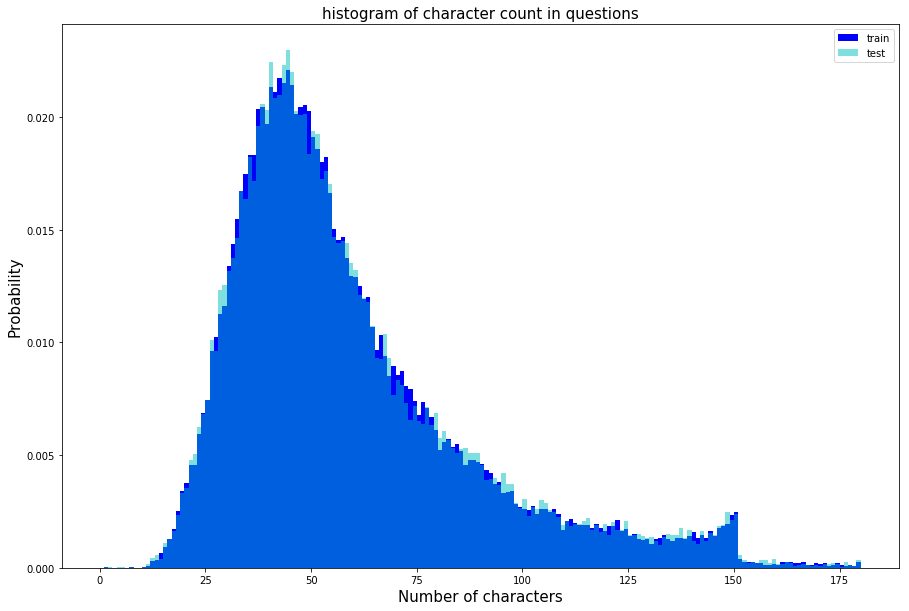

The mean of length of questions in train is: 59.6954 and test is 59.826266313315664



In [43]:
train = pd.Series(df_vec['q1len'][0:40000].tolist() + df_vec['q2len'][0:40000].tolist())
test = pd.Series(df_vec['q1len'][40001:60000].tolist() + df_vec['q2len'][40001:60000].tolist())

plt.figure(figsize=(15, 10))
plt.hist(train, bins=180, range=[0, 180], color='b', normed=True, label='train')
plt.hist(test, bins=180, range=[0, 180], color='c', normed=True, alpha=0.5, label='test')
plt.legend()
plt.title('histogram of character count in questions', fontsize=15)
plt.xlabel('Number of characters', fontsize=15)
plt.ylabel('Probability', fontsize=15)
plt.show()


print ('The mean of length of questions in train is: {} and test is {}\n'.format(np.mean(train),np.mean(test))) 

We can see that both train and test follow the same distribution and mean is around 60

## Pair plots of basic features

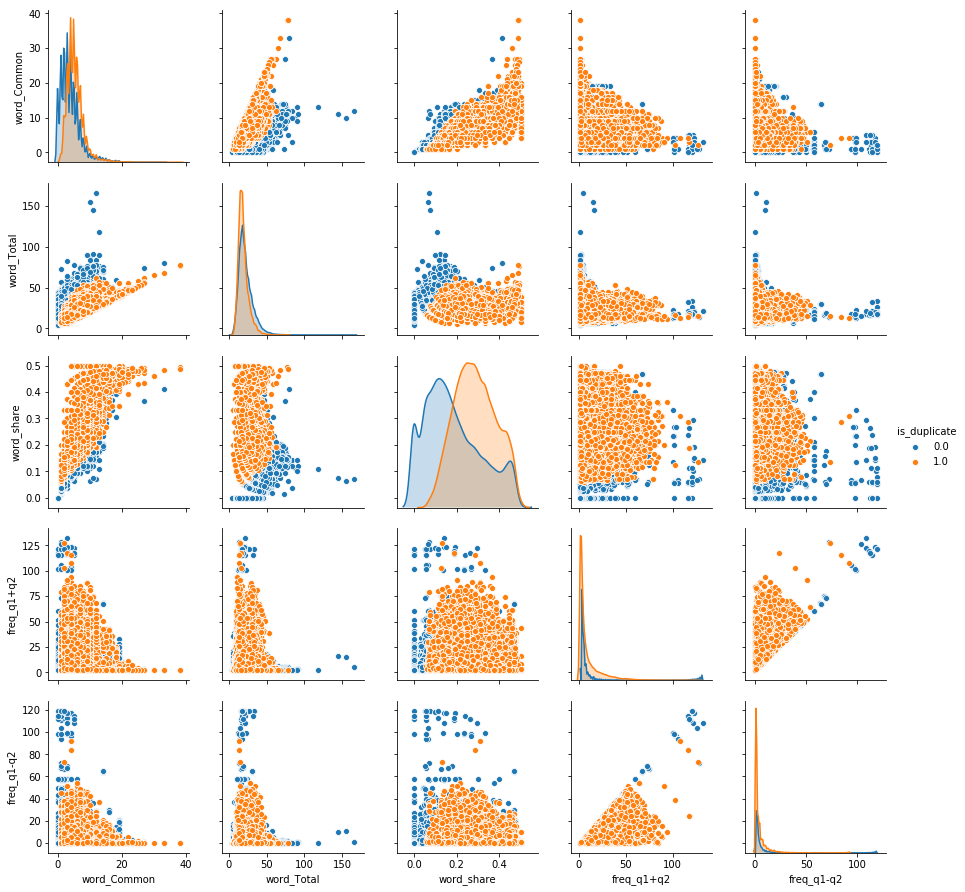

In [55]:
#n = df.shape[0]
sns.pairplot((dfppro[['word_Common','word_Total','word_share','freq_q1+q2','freq_q1-q2']]).join(dfnlp['is_duplicate']),hue='is_duplicate', vars=['word_Common','word_Total','word_share','freq_q1+q2','freq_q1-q2'])

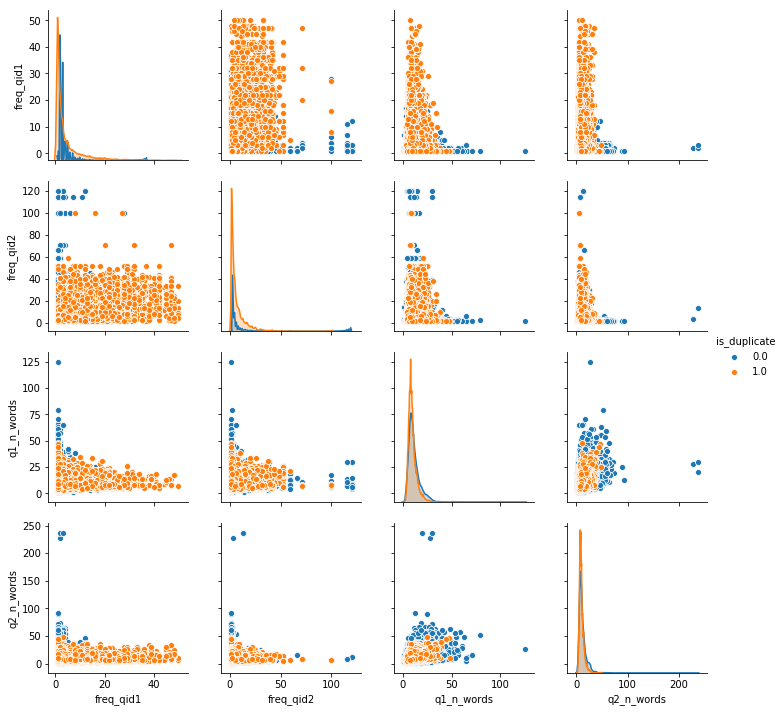

In [57]:
sns.pairplot((dfppro[['freq_qid1','freq_qid2','q1_n_words','q2_n_words']]).join(dfnlp['is_duplicate']),hue='is_duplicate', vars=['freq_qid1','freq_qid2','q1_n_words','q2_n_words'])

The features are important in classifying the points.

In [60]:
dfc=dfppro[['word_Common','word_Total','word_share','freq_q1+q2','freq_q1-q2']].join(dfnlp['is_duplicate'])

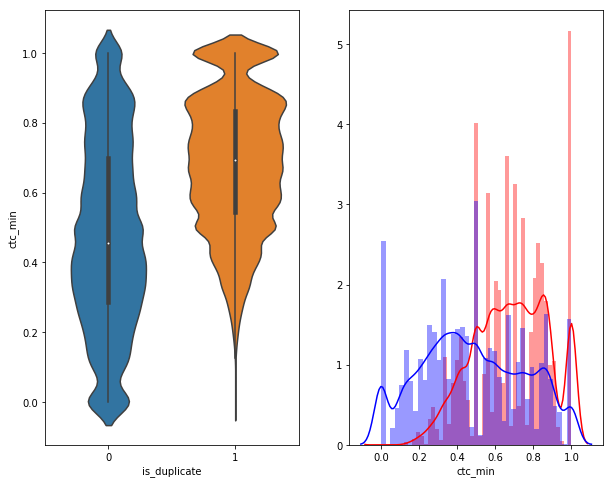

In [65]:
# Distribution of the ctc_min
plt.figure(figsize=(10, 8))

plt.subplot(1,2,1)
sns.violinplot(x = 'is_duplicate', y ='ctc_min', data = dfnlp[['is_duplicate','ctc_min']] , )

plt.subplot(1,2,2)
sns.distplot(dfnlp[dfnlp['is_duplicate'] == 1.0]['ctc_min'][0:] , label = "1", color = 'red')
sns.distplot(dfnlp[dfnlp['is_duplicate'] == 0.0]['ctc_min'][0:] , label = "0" , color = 'blue' )
plt.show()

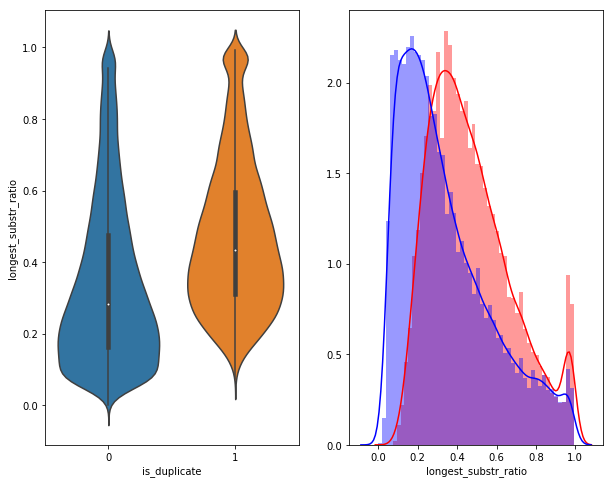

In [69]:
# Distribution of the longest_substr_ratio
plt.figure(figsize=(10, 8))

plt.subplot(1,2,1)
sns.violinplot(x = 'is_duplicate', y ='longest_substr_ratio', data = dfnlp[['is_duplicate','longest_substr_ratio']] , )

plt.subplot(1,2,2)
sns.distplot(dfnlp[dfnlp['is_duplicate'] == 1.0]['longest_substr_ratio'][0:] , label = "1", color = 'red')
sns.distplot(dfnlp[dfnlp['is_duplicate'] == 0.0]['longest_substr_ratio'][0:] , label = "0" , color = 'blue' )
plt.show()

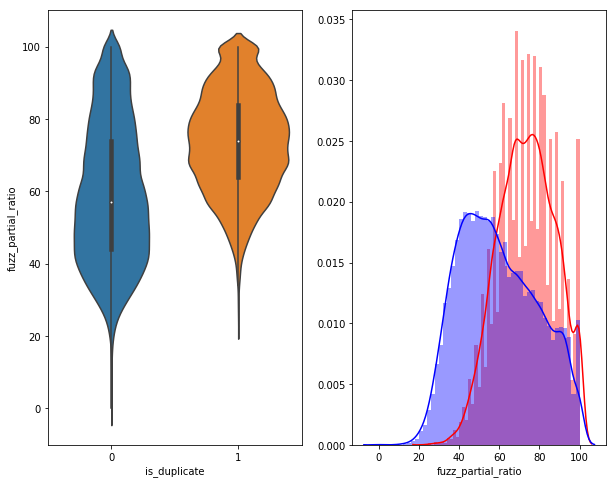

In [70]:
# Distribution of the fuzz_partial_ratio
plt.figure(figsize=(10, 8))

plt.subplot(1,2,1)
sns.violinplot(x = 'is_duplicate', y ='fuzz_partial_ratio', data = dfnlp[['is_duplicate','fuzz_partial_ratio']] , )

plt.subplot(1,2,2)
sns.distplot(dfnlp[dfnlp['is_duplicate'] == 1.0]['fuzz_partial_ratio'][0:] , label = "1", color = 'red')
sns.distplot(dfnlp[dfnlp['is_duplicate'] == 0.0]['fuzz_partial_ratio'][0:] , label = "0" , color = 'blue' )
plt.show()

## Wordcloud of highest tfidf feature corresponding to y=0/1

In [83]:
idx=dfnlp.index[dfnlp['is_duplicate'] == 1]
positive=dfnlp.loc[idx, ['question1', 'question2']]
idz=dfnlp.index[dfnlp['is_duplicate'] == 0]
negative=dfnlp.loc[idz, ['question1', 'question2']]


In [95]:
#vectorizing the questions corresponding to y=1
tf_idf_vect = TfidfVectorizer(ngram_range=(1,2), min_df=10)
vec_pos=tf_idf_vect.fit_transform(positive['question1']+positive['question2'])

In [97]:
#getting the features with top tfidf values
features=pd.DataFrame(tf_idf_vect.get_feature_names())
mean_tf=np.mean(vec_pos,axis=0)
x=np.array(mean_tf)[0].tolist()
# taking top 20 features
important_feat=[]
important_feat=np.argsort((x))[::-1]
important_feat=important_feat[:100]
important_feat
imp_feat=[]
for index in important_feat:
    imp_feat.append(features.iloc[index])
    
x=np.array(imp_feat)
feature=[]
for i in x:
    for j in i:
        feature.append(j)

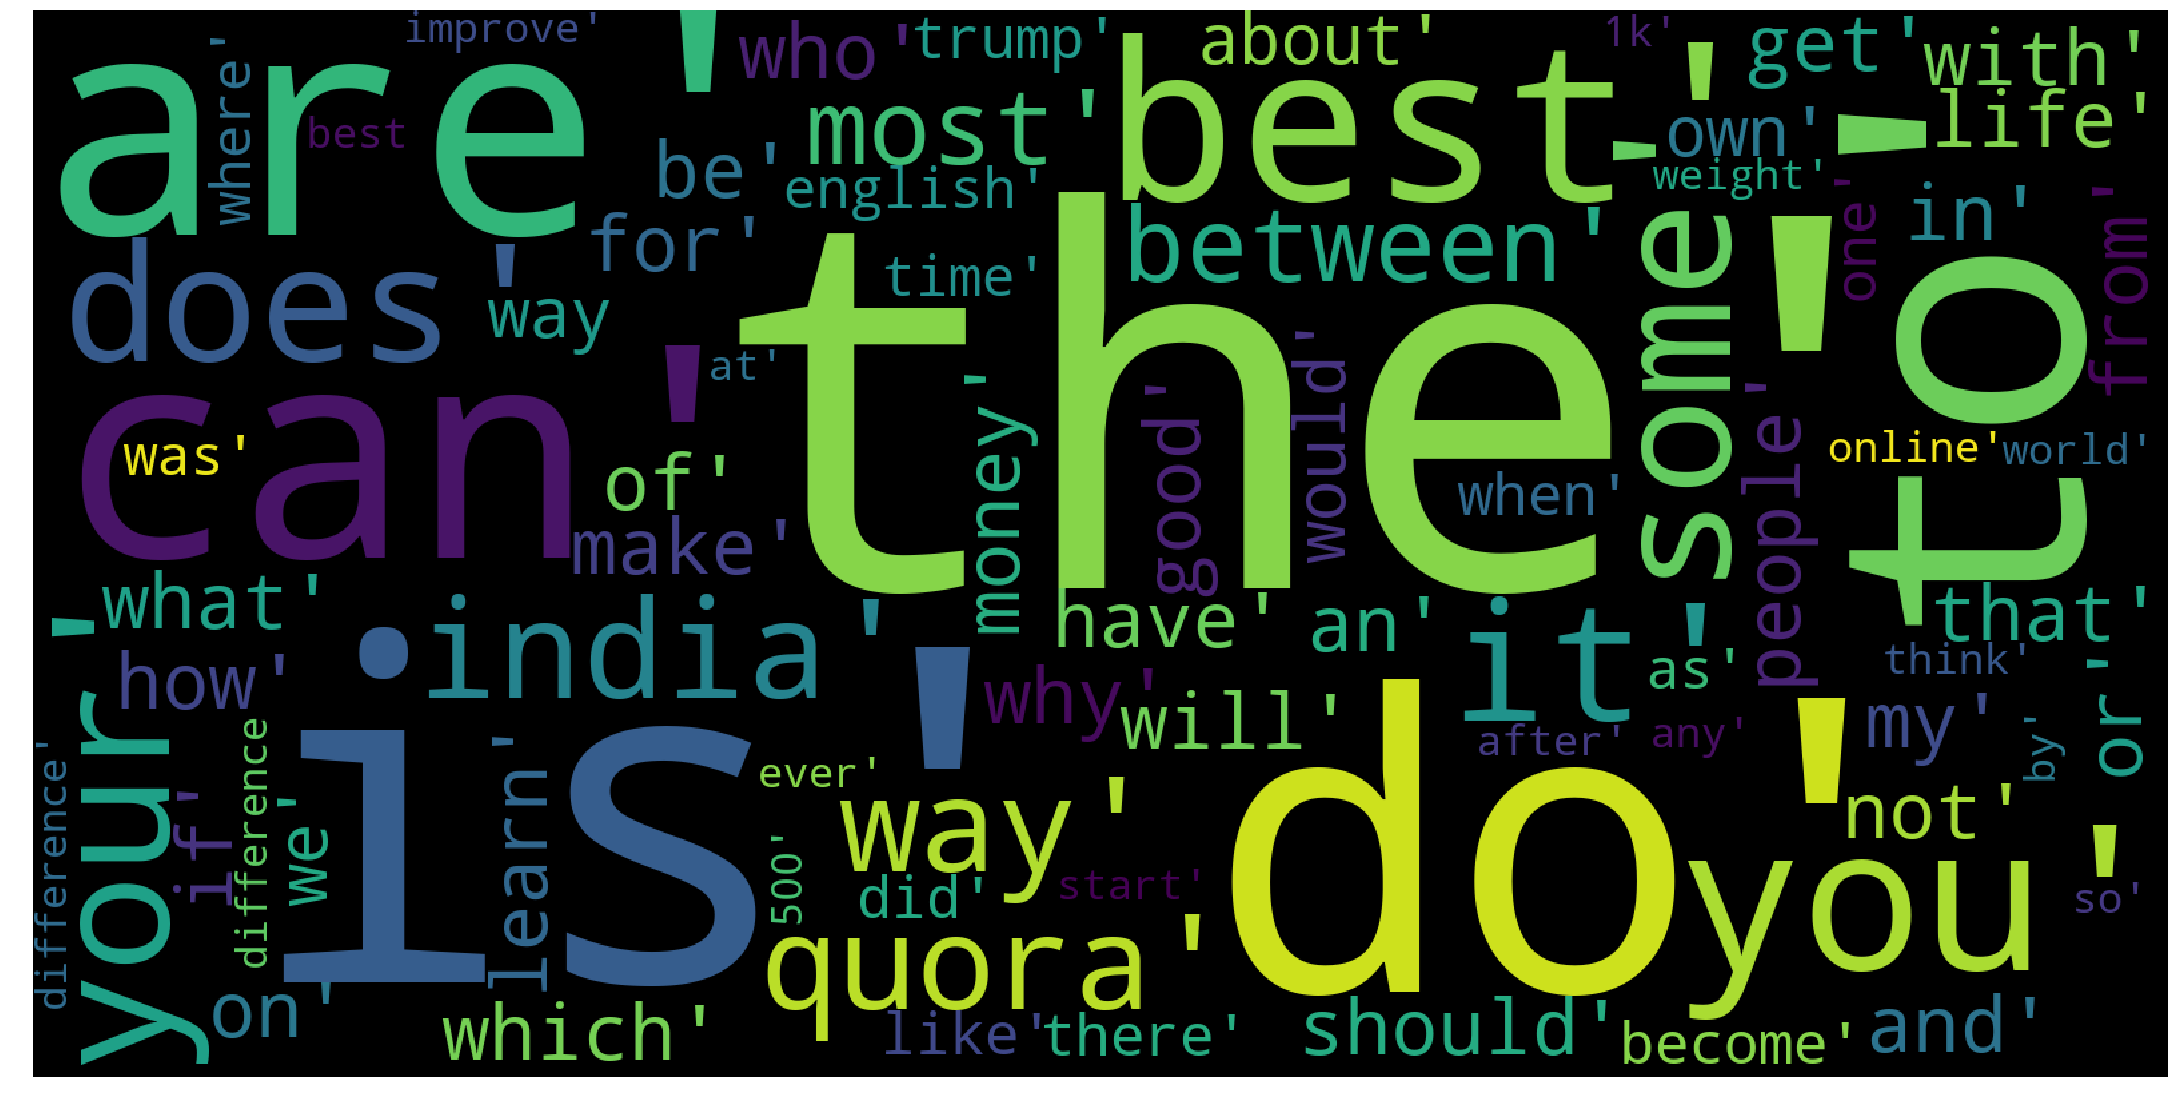

In [102]:

from wordcloud import WordCloud
# Ploting word cloud
# Lets first convert the 'result' dictionary to 'list of tuples'
#tup = dict(result.items())
#Initializing WordCloud using frequencies of tags.
wordcloud = WordCloud(    background_color='black',
                          width=1600,
                          height=800,
                    ).generate(str(feature))

fig = plt.figure(figsize=(30,20))
plt.imshow(wordcloud)
plt.axis('off')
plt.tight_layout(pad=0)
fig.savefig("tag.png")
plt.show()

In [103]:
#vectorizing the questions corresponding to y=0
tf_idf_vect = TfidfVectorizer(ngram_range=(1,2), min_df=10)
vec_pos=tf_idf_vect.fit_transform(negative['question1']+negative['question2'])

In [105]:
#getting the features with top tfidf values
features=pd.DataFrame(tf_idf_vect.get_feature_names())
mean_tf=np.mean(vec_pos,axis=0)
x=np.array(mean_tf)[0].tolist()
# taking top 20 features
important_feat=[]
important_feat=np.argsort((x))[::-1]
important_feat=important_feat[:100]
important_feat
imp_feat=[]
for index in important_feat:
    imp_feat.append(features.iloc[index])
    
x=np.array(imp_feat)
feature=[]
for i in x:
    for j in i:
        feature.append(j)


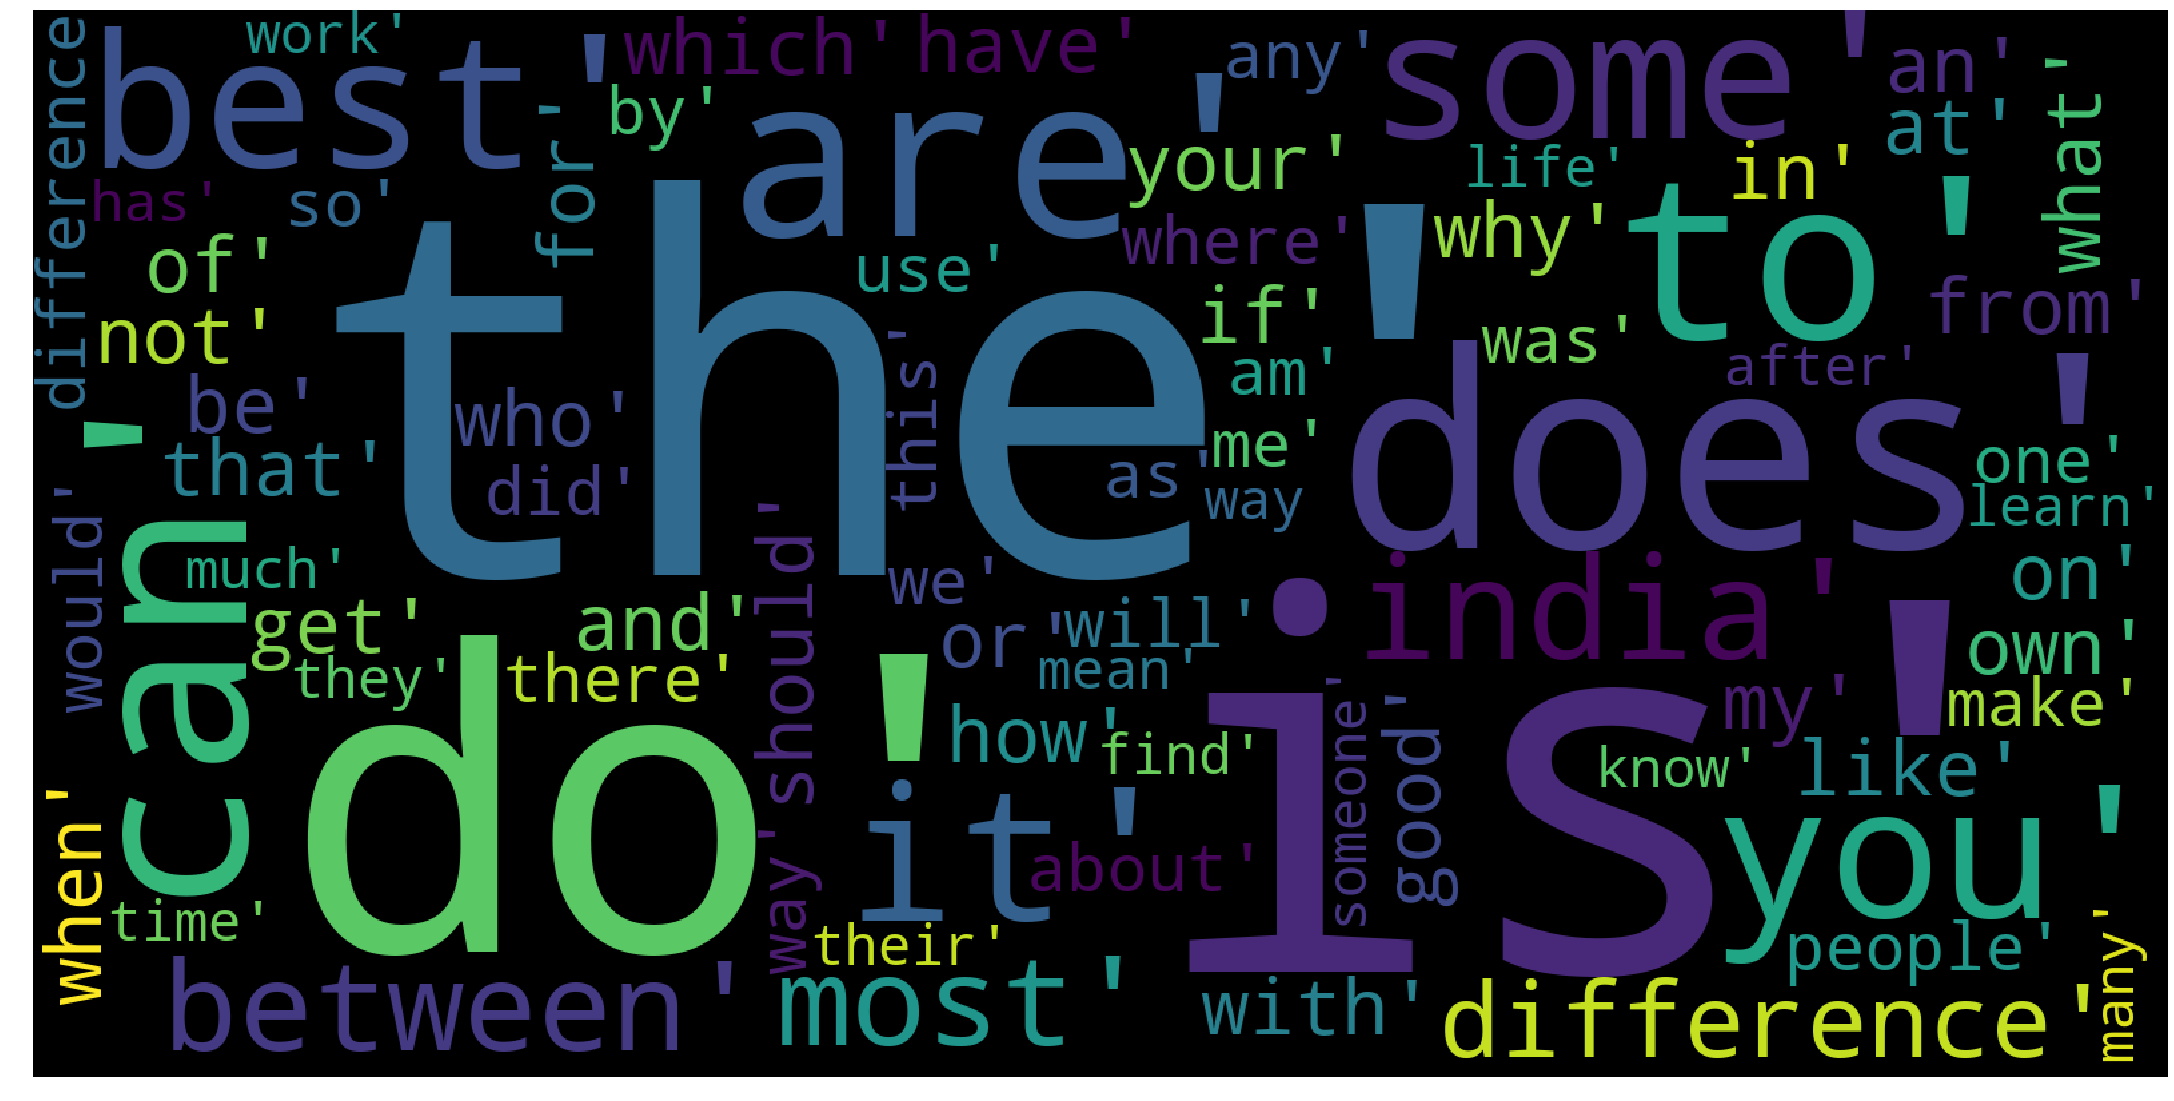

In [106]:

from wordcloud import WordCloud
# Ploting word cloud
# Lets first convert the 'result' dictionary to 'list of tuples'
#tup = dict(result.items())
#Initializing WordCloud using frequencies of tags.
wordcloud = WordCloud(    background_color='black',
                          width=1600,
                          height=800,
                    ).generate(str(feature))

fig = plt.figure(figsize=(30,20))
plt.imshow(wordcloud)
plt.axis('off')
plt.tight_layout(pad=0)
fig.savefig("tag.png")
plt.show()

The wordcloud for questions coresponding to both y=0/1 contains similar words.

## TFIDF vectorization

In [4]:
if os.path.isfile('nlp_features_train.csv'):
    dfnlp = pd.read_csv("nlp_features_train.csv",encoding='latin-1')

In [6]:
#filling the null vlues
dfnlp=dfnlp.fillna(' ')

In [7]:
dfnlp.isnull().any()

id                      False
qid1                    False
qid2                    False
question1               False
question2               False
is_duplicate            False
cwc_min                 False
cwc_max                 False
csc_min                 False
csc_max                 False
ctc_min                 False
ctc_max                 False
last_word_eq            False
first_word_eq           False
abs_len_diff            False
mean_len                False
token_set_ratio         False
token_sort_ratio        False
fuzz_ratio              False
fuzz_partial_ratio      False
longest_substr_ratio    False
dtype: bool

In [8]:
#splitting manually into train and test
dfnlp=dfnlp[0:60000]
dfnlp.shape
dfnlp_train=dfnlp[0:40000]
dfnlp_test=dfnlp[40001:60000]

In [16]:
print(dfnlp_train.shape)
dfnlp_test.shape

(40000, 21)


(19999, 21)

In [17]:
# tfidf vectorization with n_gram=2
tf_idf_vect = TfidfVectorizer(ngram_range=(1,2), min_df=10)
train_vec_1=tf_idf_vect.fit_transform(dfnlp_train['question1'])
test_vec_1=tf_idf_vect.transform(dfnlp_test['question1'])
train_vec_2=tf_idf_vect.fit_transform(dfnlp_train['question2'])
test_vec_2=tf_idf_vect.transform(dfnlp_test['question2'])


In [18]:
if os.path.isfile('df_fe_without_preprocessing_train.csv'):
    dfppro = pd.read_csv("df_fe_without_preprocessing_train.csv",encoding='latin-1')

In [19]:
#stacking the train vectors of question 1 and two
from scipy import sparse
train_q=sparse.hstack([train_vec_1,train_vec_2])
#stacking the test vectors of question 1 and two
test_q=sparse.hstack([test_vec_1,test_vec_2])
train_q.shape


(40000, 14983)

In [20]:
#getting rest of advanced features
df_vec=dfnlp[['cwc_min','cwc_max','csc_min','csc_max','ctc_min','ctc_max','last_word_eq','first_word_eq','abs_len_diff','mean_len','token_set_ratio','token_sort_ratio','fuzz_ratio','fuzz_partial_ratio','longest_substr_ratio']].join(dfppro[['freq_qid1','freq_qid2','q1len','q2len','q1_n_words','q2_n_words','word_Common','word_Total','word_share','freq_q1+q2','freq_q1-q2']])

In [21]:
#y labels
train_y=dfnlp['is_duplicate'][0:40000]
test_y=dfnlp['is_duplicate'][40001:60000]

In [22]:
#stacking advanced features and tfidf vectors
train_vecs=sparse.hstack([train_q,df_vec[0:40000]])
test_vecs=sparse.hstack([test_q,df_vec[40001:60000]])

In [23]:
train_vecs.shape

(40000, 15009)

## Logistic Regression with hyperparameter tuning

For values of alpha =  1e-05 The log loss is: 0.46184114657478476
For values of alpha =  0.0001 The log loss is: 0.4564201176731175
For values of alpha =  0.001 The log loss is: 0.45756864449921325
For values of alpha =  0.01 The log loss is: 0.4585507362678816
For values of alpha =  0.1 The log loss is: 0.460880908451455
For values of alpha =  1 The log loss is: 0.4935858896035705
For values of alpha =  10 The log loss is: 0.5480599551149273



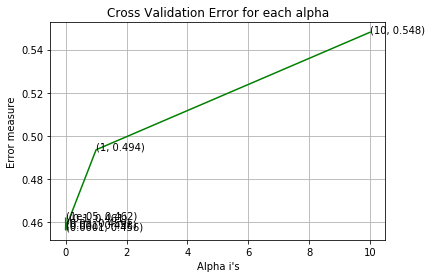

For values of best alpha =  0.0001 The train log loss is: 0.45278879999465105
For values of best alpha =  0.0001 The test log loss is: 0.4564201176731175
Total number of data points : 19999


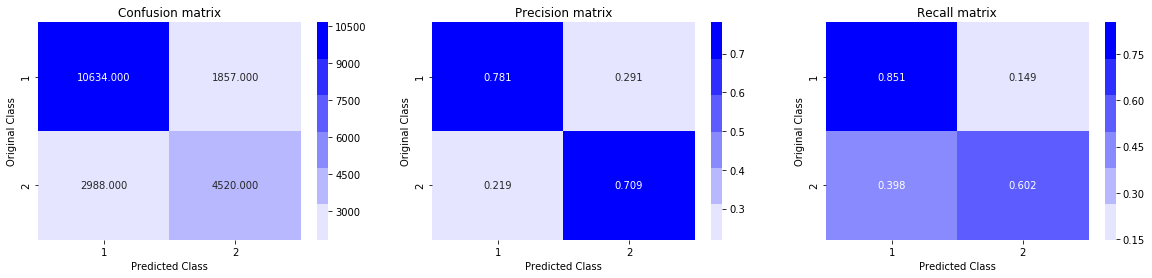

In [85]:
from tqdm.auto import tqdm
alpha = [10 ** x for x in range(-5, 2)] # hyperparam for SGD classifier.

log_error_array=[]
for i in tqdm(alpha):
    clf = SGDClassifier(alpha=i, penalty='l2', loss='log', random_state=42)
    clf.fit(train_vecs, train_y)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_vecs, train_y)
    predict_y = sig_clf.predict_proba(test_vecs)
    log_error_array.append(log_loss(test_y, predict_y, labels=clf.classes_, eps=1e-15))
    print('For values of alpha = ', i, "The log loss is:",log_loss(test_y, predict_y, labels=clf.classes_, eps=1e-15))

fig, ax = plt.subplots()
ax.plot(alpha, log_error_array,c='g')
for i, txt in enumerate(np.round(log_error_array,3)):
    ax.annotate((alpha[i],np.round(txt,3)), (alpha[i],log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha = np.argmin(log_error_array)
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
clf.fit(train_vecs, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_vecs, train_y)

predict_y = sig_clf.predict_proba(train_vecs)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(train_y, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(test_vecs)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(test_y, predict_y, labels=clf.classes_, eps=1e-15))
predicted_y =np.argmax(predict_y,axis=1)
print("Total number of data points :", len(predicted_y))
plot_confusion_matrix(test_y, predicted_y)

## Linear SVM with hyperparameter tuning

For values of alpha =  1e-05 The log loss is: 0.4636498119106351
For values of alpha =  0.0001 The log loss is: 0.4789319096072303
For values of alpha =  0.001 The log loss is: 0.48969325832950694
For values of alpha =  0.01 The log loss is: 0.5018947372269298
For values of alpha =  0.1 The log loss is: 0.4765511555383432
For values of alpha =  1 The log loss is: 0.6052293455226234
For values of alpha =  10 The log loss is: 0.6074137784736146



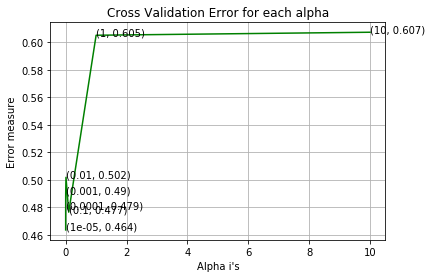

For values of best alpha =  1e-05 The train log loss is: 0.45968365849046866
For values of best alpha =  1e-05 The test log loss is: 0.4636498119106351
Total number of data points : 19999


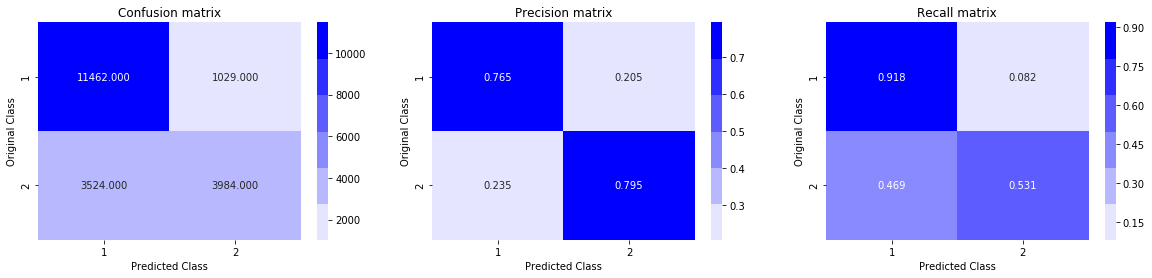

In [86]:
alpha = [10 ** x for x in range(-5, 2)] # hyperparam for SGD classifier.
--


log_error_array=[]
for i in tqdm(alpha):
    clf = SGDClassifier(alpha=i, penalty='l1', loss='hinge', random_state=42)
    clf.fit(train_vecs, train_y)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_vecs, train_y)
    predict_y = sig_clf.predict_proba(test_vecs)
    log_error_array.append(log_loss(test_y, predict_y, labels=clf.classes_, eps=1e-15))
    print('For values of alpha = ', i, "The log loss is:",log_loss(test_y, predict_y, labels=clf.classes_, eps=1e-15))

fig, ax = plt.subplots()
ax.plot(alpha, log_error_array,c='g')
for i, txt in enumerate(np.round(log_error_array,3)):
    ax.annotate((alpha[i],np.round(txt,3)), (alpha[i],log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha = np.argmin(log_error_array)
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l1', loss='hinge', random_state=42)
clf.fit(train_vecs, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_vecs, train_y)

predict_y = sig_clf.predict_proba(train_vecs)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(train_y, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(test_vecs)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(test_y, predict_y, labels=clf.classes_, eps=1e-15))
predicted_y =np.argmax(predict_y,axis=1)
print("Total number of data points :", len(predicted_y))
plot_confusion_matrix(test_y, predicted_y)

## XGBOOST

In [151]:
import xgboost as xgb
# with glove vectorization
from scipy.stats import randint as sp_randint
from sklearn.model_selection import RandomizedSearchCV
g=sp_randint(1, 50)
# using randomsearch for hyperparameter tuning
xg=xgb.XGBClassifier(nthread=-1, early_stopping_rounds=20, verbose_eval=10)
params = {}
params['n_estimators']=[10,100]
params['max_depth'] = sp_randint(1, 50)

random_search = RandomizedSearchCV(xg,cv=5, param_distributions=params,\
                                     n_jobs=-1,verbose=10 ,scoring='neg_log_loss')
random_search.fit(X_train,y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed: 43.4min
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed: 67.9min
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed: 92.7min
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed: 122.2min
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed: 142.2min
[Parallel(n_jobs=-1)]: Done  41 out of  50 | elapsed: 148.2min remaining: 32.5min
[Parallel(n_jobs=-1)]: Done  47 out of  50 | elapsed: 164.2min remaining: 10.5min
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed: 166.7min finished


'estimators=[]\n    depth=[]\n    key_scores={}\n\n    #storing the results\n    all_c = clf.cv_results_[\'params\']\n\n    #seperating max_depth and min_samples_split results\n    for i in range(len(all_c)):\n        estimators.append(all_c[i][\'n_estimators\'])\n        depth.append(all_c[i][\'max_depth\'])\n\n    scores_mean_cv = clf.cv_results_[\'mean_test_score\']\n    scores_mean_train = clf.cv_results_[\'mean_train_score\']\n\n    for a,b,c in zip(estimators ,depth,scores_mean_cv):\n        key_scores[a,b]=c\n\n    print("the auc score for various values of n_estimators and depth are: ",key_scores)\n    print("tuned hpyerparameters :(best parameters) ",clf.best_params_)\n    print("best auc :",clf.best_score_)\n    \n    #plotting the validation auc using heatmaps\n    scores_mean_cv=np.reshape(scores_mean_cv,(4,2))\n    scores_mean_train=np.reshape(scores_mean_train,(4,2))\n    \n    fig, ax = plt.subplots(ncols=2,figsize=(12,5)) \n    sns.heatmap(scores_mean_cv,annot=True,fmt=

In [174]:
random_search.best_params_

{'max_depth': 7, 'n_estimators': 100}

In [153]:
#building a model with depth=7 and n_estimators=100
import xgboost as xgb
params = {}
params['objective'] = 'binary:logistic'
params['eval_metric'] = 'logloss'
params['eta'] = 0.02
params['max_depth'] = 7
params['n_estimators']=100

d_train = xgb.DMatrix(X_train, label=y_train)
d_test = xgb.DMatrix(X_test, label=y_test)

watchlist = [(d_train, 'train'), (d_test, 'valid')]

bst = xgb.train(params, d_train, 400, watchlist, early_stopping_rounds=20, verbose_eval=10)

xgdmat = xgb.DMatrix(X_train, label=y_train)
predict_y = bst.predict(d_test)
print("The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

[12:23:12] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 220 extra nodes, 0 pruned nodes, max_depth=7
[0]	train-logloss:0.683169	valid-logloss:0.683406
Multiple eval metrics have been passed: 'valid-logloss' will be used for early stopping.

Will train until valid-logloss hasn't improved in 20 rounds.
[12:23:14] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 214 extra nodes, 0 pruned nodes, max_depth=7
[12:23:16] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 216 extra nodes, 0 pruned nodes, max_depth=7
[12:23:17] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 216 extra nodes, 0 pruned nodes, max_depth=7
[12:23:19] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 216 extra nodes, 0 pruned nodes, max_depth=7
[12:23:20] C:\Users\Administrator\Deskt

[12:24:42] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 204 extra nodes, 0 pruned nodes, max_depth=7
[12:24:44] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 212 extra nodes, 0 pruned nodes, max_depth=7
[12:24:46] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 204 extra nodes, 0 pruned nodes, max_depth=7
[12:24:49] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 210 extra nodes, 0 pruned nodes, max_depth=7
[12:24:51] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 226 extra nodes, 0 pruned nodes, max_depth=7
[12:24:53] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 224 extra nodes, 0 pruned nodes, max_depth=7
[12:24:55] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pru

[12:28:07] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 150 extra nodes, 0 pruned nodes, max_depth=7
[12:28:09] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 180 extra nodes, 0 pruned nodes, max_depth=7
[12:28:11] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 146 extra nodes, 0 pruned nodes, max_depth=7
[12:28:13] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 130 extra nodes, 0 pruned nodes, max_depth=7
[12:28:15] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 162 extra nodes, 0 pruned nodes, max_depth=7
[12:28:16] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 146 extra nodes, 0 pruned nodes, max_depth=7
[160]	train-logloss:0.319374	valid-logloss:0.356443
[12:28:19] C:\Users\Administrator\De

[12:31:28] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 162 extra nodes, 0 pruned nodes, max_depth=7
[12:31:30] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 138 extra nodes, 0 pruned nodes, max_depth=7
[260]	train-logloss:0.283932	valid-logloss:0.342688
[12:31:32] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 120 extra nodes, 0 pruned nodes, max_depth=7
[12:31:34] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 138 extra nodes, 0 pruned nodes, max_depth=7
[12:31:36] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 126 extra nodes, 0 pruned nodes, max_depth=7
[12:31:37] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 158 extra nodes, 0 pruned nodes, max_depth=7
[12:31:39] C:\Users\Administrator\De

[12:33:16] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 184 extra nodes, 0 pruned nodes, max_depth=7
[12:33:18] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 64 extra nodes, 0 pruned nodes, max_depth=7
[12:33:20] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 192 extra nodes, 0 pruned nodes, max_depth=7
[12:33:22] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 194 extra nodes, 0 pruned nodes, max_depth=7
[12:33:24] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 208 extra nodes, 0 pruned nodes, max_depth=7
[12:33:26] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 158 extra nodes, 0 pruned nodes, max_depth=7
[12:33:28] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree prun

Total number of data points : 18000


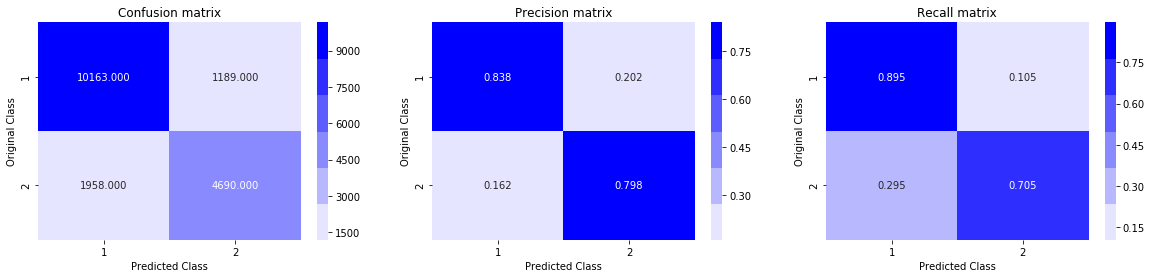

In [173]:
predicted_y =np.array(predict_y>0.5,dtype=int)
print("Total number of data points :", len(predicted_y))
plot_confusion_matrix(y_test, predicted_y)

## Conclusion:
    

Objective:
Identify which questions asked on Quora are duplicates of questions that have already been asked.
This could be useful to instantly provide answers to questions that have already been answered.
We are tasked with predicting whether a pair of questions are duplicates or not.

1. We are given a dataset with 4M rows and 5 columns: qid1,qid2,question1,question2,is_duplicate of which is_duplicate is a binary column containing whether the two questions are similar or not(1 or 0).
<br>
2. We perform EDA on the dataset to know about the distribution of the data and get more insights about the data.
<br>
3. Next we perform feature extraction to get some important features like length, common words which might be helpful to classify and then we go for advance feature extraction like fuzzy wuzzy.
<br>
4. We then preprocess the data to remove html tags etc and then visualize using wordclouds.
<br>
5. We then perform eda to know which of the features are actually important in classification using pairplots and histograms.
<br>
6. We convert the questions into vectors using tfidf glove vectorization and stack the features extracted to it (question1+question2+basic features+advance features).
<br>
7. We apply various model like logistic regression, linear svm and xgboost and compare them.
<br>
8. We use log loss and confusion matrix as the performance metric to compare various models.
<br>
9. we also try tfidf vectors on linear svm and logistic regression and hyperparameter tune xgboost model to furthur reduce the log loss.


In [1]:
from prettytable import PrettyTable

x=PrettyTable()

x.field_names=['Algorithm','Vectorizer','alpha','max_depth','train log-loss','test log-loss']
x.add_row(["Logistic Regression","TFIDF-GLOVE",10,'-',0.513, 0.522 ])
x.add_row(["Linear SVM","TFIDF-GLOVE",0.0001,'-', 0.49,0.506])
x.add_row(["XGBOOST","TFIDF-GLOVE",'-',4, 0.337,0.3518])
x.add_row(["Logistic Regression","TFIDF",0.0001 ,'-', 0.452,0.456])
x.add_row(["Linear SVM","TFIDF",0.00001,'-', 0.459,0.463])
x.add_row(["XGBOOST","TFIDF-GLOVE",'-', 7,0.237,0.3348])


print(x)

+---------------------+-------------+--------+-----------+----------------+---------------+
|      Algorithm      |  Vectorizer | alpha  | max_depth | train log-loss | test log-loss |
+---------------------+-------------+--------+-----------+----------------+---------------+
| Logistic Regression | TFIDF-GLOVE |   10   |     -     |     0.513      |     0.522     |
|      Linear SVM     | TFIDF-GLOVE | 0.0001 |     -     |      0.49      |     0.506     |
|       XGBOOST       | TFIDF-GLOVE |   -    |     4     |     0.337      |     0.3518    |
| Logistic Regression |    TFIDF    | 0.0001 |     -     |     0.452      |     0.456     |
|      Linear SVM     |    TFIDF    | 1e-05  |     -     |     0.459      |     0.463     |
|       XGBOOST       | TFIDF-GLOVE |   -    |     7     |     0.237      |     0.3348    |
+---------------------+-------------+--------+-----------+----------------+---------------+


We can see that XgBoost with max depth of 7 and 100 estimators reduced the log loss to 0.334